<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/Lab08_SimpleRNN_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os

from torch import nn


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
dpath = '/content/drive/MyDrive/data/ecg/training2017'
d = pd.read_csv(os.path.join(dpath,'REFERENCE.csv'),header=None)
Nlist = d[d[1]=='N']
Alist = d[d[1]=='A']
print(len(Nlist),len(Alist))
#d[:3]

5050 738


In [9]:
d[:9]

,0,1
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A
5,A00006,N
6,A00007,N
7,A00008,O
8,A00009,A


## 데이터 나누기
- A, N 리스트로부터 뒤의 100명의 데이터를 validation set, 앞의 600명의 데이터를 training set로 나눕니다.

In [10]:
Ntr = 600
Nvd = 100
Nlist_vd = Nlist[-Nvd:]
Alist_vd = Alist[-Nvd:]
Nlist = Nlist[:Ntr]
Alist = Alist[:Ntr]
print(len(Nlist),len(Alist), len(Nlist_vd),len(Alist_vd))

600 600 100 100


## Data Loader를 생성하기
- 정해진 batch_size에 맞추어 두 클래스의 데이터를 같은 숫자로 랜덤하게 추출할 수 있도록 합니다.
- 적절한 전처리를 포함하고, 데이터의 변형을 랜덤으로 주는 과정을 추가해 볼 수 있습니다.

In [11]:
def data_iter(batch_size, dpath, Nlist, Alist, L):

    num_examplesN = len(Nlist)
    num_examplesA = len(Alist)
    indicesN = list(range(num_examplesN))
    indicesA = list(range(num_examplesA))

    random.shuffle(indicesN)
    batch_size2 = int(batch_size/2)

    ma = np.ones(128)/128.

    for i in range(0, num_examplesN, batch_size):
        batch_indicesN = indicesN[i:min(i+batch_size2, num_examplesN)]
        random.shuffle(indicesA)
        features = torch.zeros((batch_size,L))
        labels = torch.zeros((batch_size,))
        for bi in range(0, len(batch_indicesN)):
            sign = sio.loadmat(os.path.join(dpath,Nlist.iloc[batch_indicesN[bi],0]+'.mat'))
            siga = sio.loadmat(os.path.join(dpath,Alist.iloc[indicesA[bi],0]+'.mat'))
            sign = sign['val'][0]
            siga = siga['val'][0]

            sign = sign - np.convolve(sign,ma,mode='same')
            siga = siga - np.convolve(siga,ma,mode='same')

            sign = (sign - np.mean(sign))/np.std(sign)
            siga = (siga - np.mean(siga))/np.std(siga)

            r1 = random.randint(int(len(sign)*0),int(len(sign)*.3))
            r2 = random.randint(int(len(siga)*0),int(len(siga)*.3))

            sign = torch.tensor(sign[r1:r1+L]) * (random.randint(50,200)/100.) + (random.randint(-50,50)/100.)
            siga = torch.tensor(siga[r2:r2+L]) * (random.randint(50,200)/100.) + (random.randint(-50,50)/100.)

            n1 = (random.randint(-10,10)/100.)*torch.normal(torch.zeros(len(sign)),torch.ones(len(sign)))
            n2 = (random.randint(-10,10)/100.)*torch.normal(torch.zeros(len(siga)),torch.ones(len(siga)))

            sign = sign + n1
            siga = siga + n2

            features[2*bi,:len(sign)] = sign
            features[2*bi+1,:len(siga)] = siga

            labels[2*bi] = 0
            labels[2*bi+1] = 1

        yield features[:,:L], labels

torch.Size([2, 500])
torch.Size([2])


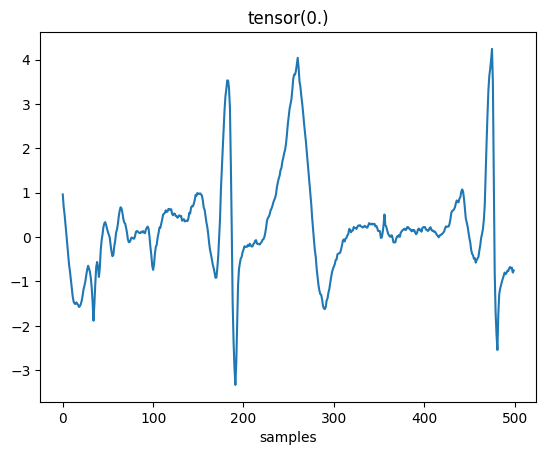

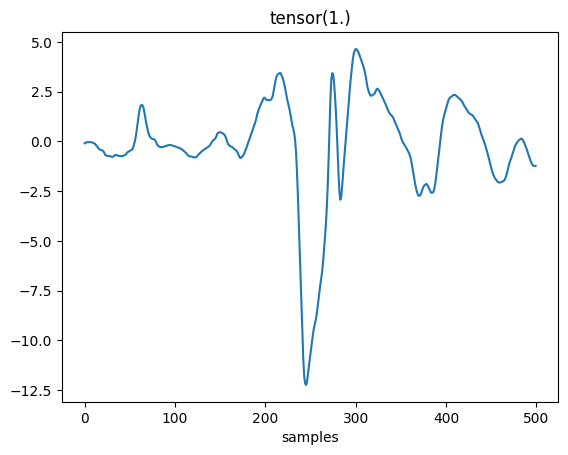

In [12]:
L = 500
for X_tr, y_tr in data_iter(2,dpath,Nlist_vd,Alist_vd,L):
    print(X_tr.shape)
    print(y_tr.shape)
    for n in range(2):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break

## RNN model 정의하기
- PyTorch의 RNN, LSTM, GRU를 활용한 model을 정의합니다.
- Feature extractor와 Classifier를 구분하여 model을 구성하는 layer들을 정의합니다.
- Forward함수의 정의를 통해 model의 forward연산의 방법을 정의하는 과정을 이해합니다.

In [13]:
class myRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):

        super().__init__()

        self.features = torch.nn.Sequential(
            torch.nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=False,
                          dropout=0.3),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1*hidden_size, 1*hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.3),
        )

        self.output = torch.nn.Linear(1*hidden_size, out_size)

    def forward(self, x):
        features, _ = self.features(x)
        output = self.classifier(features)
        output = self.output(output)
        return output

## RNN model 생성하기
- 입력데이터의 크기, 히든유닛의 크기, RNN hidden layer의 개수, 출력 클래스의 개수를 정하여 RNN model을 생성합니다.

In [14]:
net = myRNN(500,100,1,2)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


myRNN(
  (features): Sequential(
    (0): GRU(500, 100, batch_first=True, dropout=0.3)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=100, out_features=2, bias=True)
)

- learning rate, loss function, algorithm 을 정의합니다.

In [15]:
lr = 0.0042
loss = nn.CrossEntropyLoss(weight=torch.Tensor([0.5,0.5]),reduction='mean')
alg = torch.optim.AdamW(net.parameters(),lr)
epoch_tr_accuracy = []
epoch_vd_accuracy = []

## RNN Model 학습 진행하기
- data_iter로 불러온 데이터를 RNN model입력 사이즈에 맞추어 구간을 나누어 model의 입력으로 활용합니다.
- data_iter, RNNmodel, hyperparameter들을 조절하며 validation set에 대한 정확도를 최대한 높여 봅니다.

In [16]:
eval_interval = 1
num_epochs = 100
batch_size = 128
L = 10000

for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    net.train()
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        X = X_tr.view(len(X_tr),20,500)
        y_tr_pred = net(X.to(device))
        y_tr_pred = y_tr_pred[:,-1,:]
        l=loss(y_tr_pred.cpu(),y_tr.type(torch.LongTensor))
        l.backward()
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.cpu().softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1

    if epoch%eval_interval==0:
        tr_accuracy = 100*Ncorrect/(N)
        net.eval()
        for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
            X = X_vd.view(Nvd,20,500)
            with torch.no_grad():
                y_vd_pred = net(X.to(device))
            y_vd_pred = y_vd_pred[:,-1,:]
            vd_accuracy = 100*torch.sum(y_vd==torch.argmax(y_vd_pred.cpu().softmax(1),dim=1))/Nvd

        if epoch%5==0:
            print(f'epoch #{epoch}')
            print(f'accuracy of train set: {tr_accuracy} %')
            print(f'accuracy of valid set: {vd_accuracy} %')
        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

epoch #0
accuracy of train set: 51.40625 %
accuracy of valid set: 43.0 %
epoch #5
accuracy of train set: 53.59375 %
accuracy of valid set: 46.0 %
epoch #10
accuracy of train set: 63.59375 %
accuracy of valid set: 51.0 %
epoch #15
accuracy of train set: 67.5 %
accuracy of valid set: 63.0 %
epoch #20
accuracy of train set: 70.15625 %
accuracy of valid set: 66.0 %
epoch #25
accuracy of train set: 72.03125 %
accuracy of valid set: 74.0 %
epoch #30
accuracy of train set: 71.71875 %
accuracy of valid set: 75.0 %
epoch #35
accuracy of train set: 77.34375 %
accuracy of valid set: 77.0 %
epoch #40
accuracy of train set: 76.71875 %
accuracy of valid set: 77.0 %
epoch #45
accuracy of train set: 80.78125 %
accuracy of valid set: 73.0 %
epoch #50
accuracy of train set: 79.0625 %
accuracy of valid set: 72.0 %
epoch #55
accuracy of train set: 78.59375 %
accuracy of valid set: 71.0 %
epoch #60
accuracy of train set: 79.84375 %
accuracy of valid set: 78.0 %
epoch #65
accuracy of train set: 81.09375 %
a

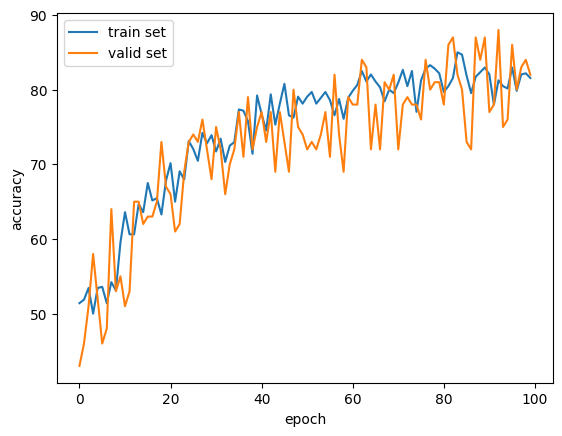

In [17]:
plt.plot(epoch_tr_accuracy)
plt.plot(epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Validation set을 통한 성능의 평가

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from enum import Enum

torch.Size([1, 18, 500])
torch.Size([1, 18, 2])
tensor([0.7918, 0.7349, 0.2276, 0.7610, 0.8915, 0.8211, 0.6680, 0.3944, 0.3935,
        0.4971, 0.6071, 0.6964, 0.5162, 0.5705, 0.7707, 0.7210, 0.7358, 0.3427],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]],
       device='cuda:0')


<ipython-input-20-4d302ee49a62>:32: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(t[::input_size],y_hat[0,:,1].detach().cpu().numpy(), use_line_collection=True)


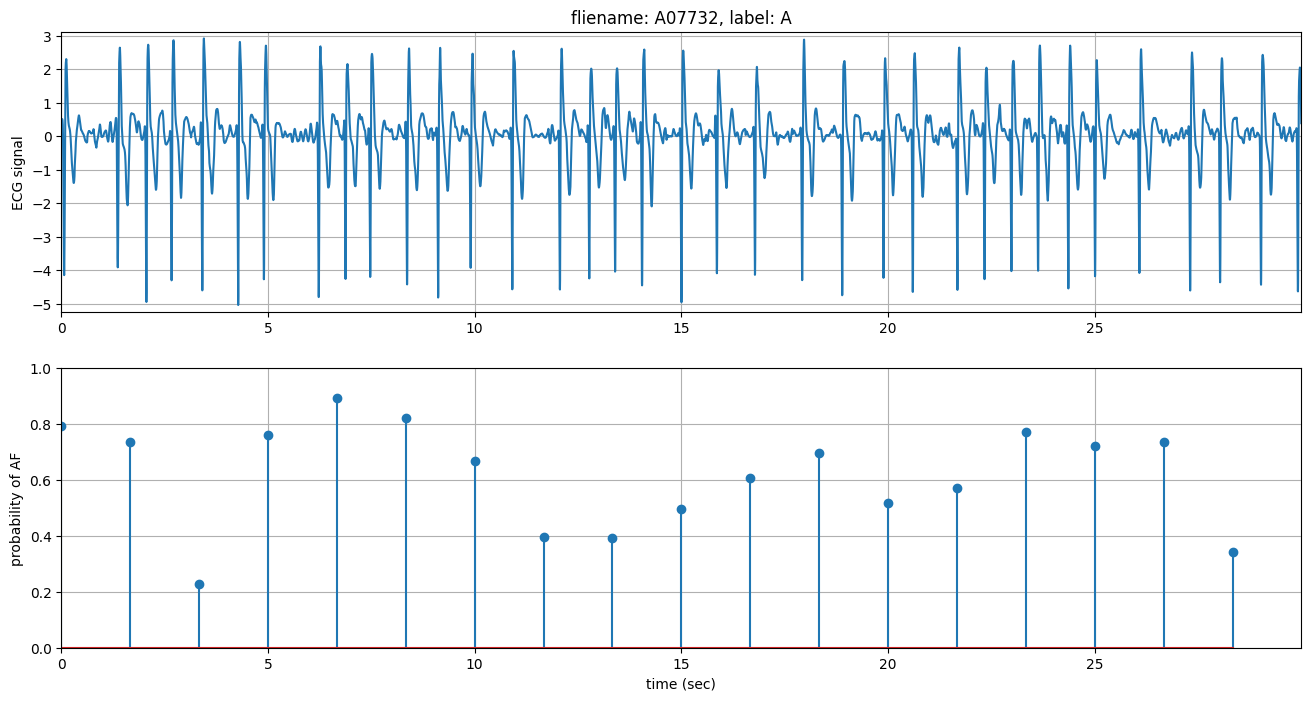

In [20]:
input_size = 500

dlist = Alist_vd
#dlist = Nlist_vd
n = 19

sig = sio.loadmat(os.path.join(dpath,dlist.iloc[n,0]+'.mat'))
sig = sig['val'][0]
sig = sig - np.convolve(sig,np.ones(128)/128.,mode='same')
sig = (sig - np.mean(sig))/np.std(sig)

N = int(np.ceil(len(sig)/input_size))
sig = np.pad(sig,[0 ,N*input_size-len(sig)])
t = np.arange(0,sig.shape[-1])/300
X = torch.Tensor(sig).view(1,N,input_size)

y_hat = net(X.to(device))
print(X.shape)
print(y_hat.shape)
print(y_hat.softmax(2)[0,:,1])
print(torch.argmax(y_hat,dim=2))

y_hat = y_hat.softmax(2)
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(t,sig)
plt.axis([0,np.max(t),np.min(sig)-.2,np.max(sig)+.2])
plt.ylabel('ECG signal')
plt.grid('on')
plt.title(f'fliename: {dlist.iloc[n,0]}, label: {dlist.iloc[n,1]}')
plt.subplot(212)
plt.stem(t[::input_size],y_hat[0,:,1].detach().cpu().numpy(), use_line_collection=True)
plt.axis([0,np.max(t),0,1])
plt.xlabel('time (sec)')
plt.ylabel('probability of AF')
plt.grid('on')
plt.show()

In [21]:
input_size = 500

y_hat_vd = np.array([])
dlist = pd.concat([Nlist_vd,Alist_vd])
y_vd = np.concatenate((np.zeros(len(Alist_vd,)),np.ones(len(Alist_vd,))),axis=0)

for n in range(len(dlist)):
    sig = sio.loadmat(os.path.join(dpath,dlist.iloc[n,0]+'.mat'))
    sig = sig['val'][0]
    sig = sig - np.convolve(sig,np.ones(128)/128.,mode='same')
    sig = (sig - np.mean(sig))/np.std(sig)
    N = int(np.ceil(len(sig)/input_size))
    sig = np.pad(sig,[0 ,N*input_size-len(sig)])
    t = np.arange(0,sig.shape[-1])/300
    X = torch.Tensor(sig).view(1,N,input_size)
    y_hat = net(X.to(device))
    y_hat_vd = np.append(y_hat_vd,y_hat.softmax(2)[0,-1,1].cpu().detach().numpy())

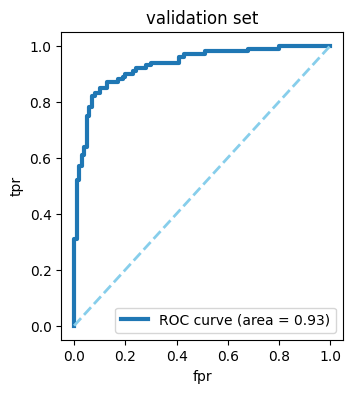

In [22]:
fpr_tr, tpr_tr, ths_tr = roc_curve(y_vd, y_hat_vd)
auc_tr = auc(fpr_tr, tpr_tr)

fig = plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(fpr_tr, tpr_tr,
        lw=3, label='ROC curve (area = %0.2f)' % auc_tr)
plt.plot([0, 1], [0, 1], color='skyblue', lw=2,linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc="lower right", prop={'size' : 10})
plt.title('validation set')
plt.show()

              precision    recall  f1-score   support

      normal       0.84      0.90      0.87       100
          AF       0.89      0.83      0.86       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



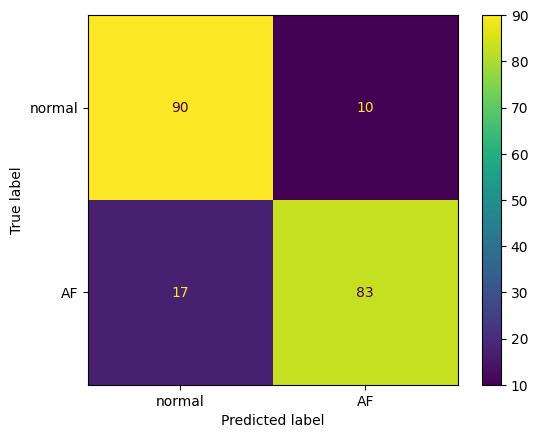

In [23]:
class Diagnosis(Enum):
    normal = 0
    AF = 1

print(classification_report(
    y_vd,
    (y_hat_vd>.5).astype(np.int8),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y_vd,
    (y_hat_vd>.5).astype(np.int8),
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

- validation set에 대해 최대한 만족스러운 결과를 만들 수 있도록 model, data_iter, hyperparameter들을 조절해봅시다.
- validation set에서 예측이 틀린 케이스들을 관찰해보고, 원인을 분석해 봅시다.
